# Project 5 - Implementing a Recommender System on Spark

By Mike Silva

## Introduction

The goal of this project is to practice beginning to work with a distributed recommender system.  I am to compare and contrast creating a recommender system on a distributed platform against one that is not.  This is the first part where I will be creating the model on my laptop.  For this project I will be using data scrapped from BoardGameGeek.com (BGG).

### About the BGG Dataset
The BoardGameGeek dataset was collected by myself by scrapping data from the API that forms the backend of [BoardGameGeek's website](https://boardgamegeek.com/). Data scrapping in ongoing but this particular data set has over 1.9 million ratings (implicit and explicit) for about 88,000 games by 219,000 users. I have previously exported the ratings from the SQLite database, then exported the data into a CSV for processing.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import seaborn as sns
import time

from surprise import BaselineOnly
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold
from surprise import accuracy

my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

%matplotlib inline

## Data Wrangling

I will begin by reading in the rating data that I have scrapped.

In [2]:
df = pd.read_csv("bgg_ratings.csv")
df

,id,item_id,user_id,rating,rating_tstamp
0,1,3,987,9.0,2016-07-29 08:22:03
1,2,3,940,9.0,2015-05-19 09:11:04
2,3,3,607,8.0,2002-08-25 00:49:42
3,4,3,8972,8.0,2004-02-28 22:32:59
4,5,3,8973,8.0,2005-10-21 12:51:52
...,...,...,...,...,...
1936354,1936355,57197,599,0.0,NaN
1936355,1936356,57197,13388,0.0,NaN
1936356,1936357,57197,9716,0.0,NaN
1936357,1936358,57197,1,0.0,NaN


There are 1.9 million ratings in the data.  The ratings provided are on a continuous scale.  We want them to be discreet so we will round them and cast them as integers.

In [3]:
df["rounded_rating"] = df["rating"].round().astype(int)

There are both explicit and implicit ratings.  The explicit ratings have a value of zero (as seen in the table above).  Here's the distribution of the ratings.

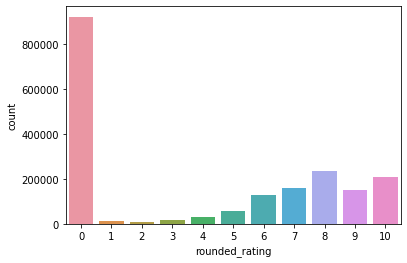

In [4]:
sns.countplot(x="rounded_rating", data=df)

As you can see from the plot above, the majority of the ratings are explicit.  I don't want to loose this information.  

### Filling in "Missing" Values

Since an implicit rating is an prediction of liking a game, I want to fill them in with high values based off of the explicit ratings.  First  I need the explicit ratings. 

In [5]:
is_an_explicit_rating = (df['rating_tstamp'].notnull()) | (df['rounded_rating'] > 0)
is_an_explicit_rating = df['rounded_rating'] > 0
explicit_rating = df[is_an_explicit_rating]
explicit_rating

,id,item_id,user_id,rating,rating_tstamp,rounded_rating
0,1,3,987,9.0,2016-07-29 08:22:03,9
1,2,3,940,9.0,2015-05-19 09:11:04,9
2,3,3,607,8.0,2002-08-25 00:49:42,8
3,4,3,8972,8.0,2004-02-28 22:32:59,8
4,5,3,8973,8.0,2005-10-21 12:51:52,8
...,...,...,...,...,...,...
1936338,1936339,40504,192811,8.0,2015-09-10 09:03:09,8
1936342,1936343,57197,57613,10.0,2012-03-10 01:14:42,10
1936343,1936344,57197,11,8.0,2012-04-04 07:18:15,8
1936344,1936345,57197,10850,8.0,2020-02-09 16:15:06,8


Let's get the descriptive statistics of the explicit ratings.

In [6]:
explicit_rating.rounded_rating.describe()

count    1.013323e+06
mean     7.609681e+00
std      1.975946e+00
min      1.000000e+00
25%      6.000000e+00
50%      8.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rounded_rating, dtype: float64

The median value is 8.  Since the implicit ratings are predictions that people will like them we will include the range from 7 on up.  Seven is included because people's prediction on how much they will like a game may be inaccurate.  I want to fill in the ratings with a distribution that is similar to the  explicit ratings (instead of filling in all values with one value).

In [7]:
explicit_rating = explicit_rating.assign(n= 1)
fill_with = explicit_rating[explicit_rating.rounded_rating > 6].groupby("rounded_rating")[["n"]].agg("sum").reset_index()

temp = dict()
total = 0

for item in fill_with.to_dict("records"):
    temp[item["rounded_rating"]] = item["n"]
    total += item["n"]
choices = list(temp.keys())
probs = [val / total for rating, val in temp.items()]
fill_with

,rounded_rating,n
0,7,161622
1,8,236835
2,9,148943
3,10,207007


Now that I have data on the distribution or the ratings I will fill in the implicit ratings.

In [8]:
implicit_rating = df[~is_an_explicit_rating]
implicit_rating = implicit_rating.assign(rounded_rating = np.random.choice(choices, len(implicit_rating.index), p=probs))
implicit_rating

,id,item_id,user_id,rating,rating_tstamp,rounded_rating
39,40,3,8992,0.0,NaN,8
40,41,3,8993,0.0,NaN,10
41,42,3,8994,0.0,NaN,10
42,43,3,975,0.0,NaN,9
43,44,3,8290,0.0,NaN,7
...,...,...,...,...,...,...
1936354,1936355,57197,599,0.0,NaN,8
1936355,1936356,57197,13388,0.0,NaN,9
1936356,1936357,57197,9716,0.0,NaN,8
1936357,1936358,57197,1,0.0,NaN,8


Now that the implicit ratings are filled in I will combine it with the implicit ratings.

In [9]:
cols = ["user_id", "item_id", "rounded_rating"]
bgg_ratings = pd.concat([explicit_rating[cols], implicit_rating[cols]])
bgg_ratings

,user_id,item_id,rounded_rating
0,987,3,9
1,940,3,9
2,607,3,8
3,8972,3,8
4,8973,3,8
...,...,...,...
1936354,599,57197,8
1936355,13388,57197,9
1936356,9716,57197,8
1936357,1,57197,8


Here's what the data now look like

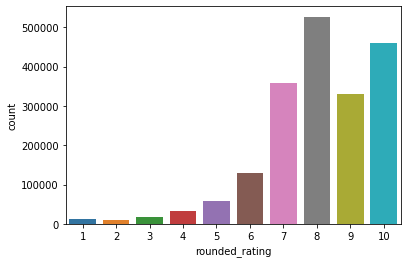

In [10]:
sns.countplot(x="rounded_rating", data=bgg_ratings)

### Reducing Sparse Data

Now that I have a data set I will deal with the sparsity of the data.  I will only keep items that have 25+ ratings.

In [11]:
counts_by_item = bgg_ratings.assign(n = 1).groupby("item_id")[["n"]].agg("sum").reset_index()
item_filter = counts_by_item[counts_by_item.n >= 25]["item_id"].tolist()
bgg_ratings = bgg_ratings[bgg_ratings.item_id.isin(item_filter)].reset_index(drop=True)
bgg_ratings

,user_id,item_id,rounded_rating
0,987,3,9
1,940,3,9
2,607,3,8
3,8972,3,8
4,8973,3,8
...,...,...,...
1556831,140931,88857,8
1556832,127677,88857,8
1556833,9074,88857,8
1556834,54125,88857,9


That leaves me with about 1.5 million ratings.  Now I will keep data from users that have rated 10 or more games.

In [12]:
counts_by_user = bgg_ratings.assign(n= 1).groupby("user_id")[["n"]].agg("sum").reset_index()
user_filter = counts_by_user[counts_by_user.n >= 10]["user_id"].tolist()
bgg_ratings = bgg_ratings[bgg_ratings.user_id.isin(user_filter)].reset_index(drop=True)
bgg_ratings

,user_id,item_id,rounded_rating
0,987,3,9
1,940,3,9
2,607,3,8
3,8972,3,8
4,8973,3,8
...,...,...,...
1125102,492113,88851,10
1125103,285304,88851,10
1125104,34632,88857,10
1125105,9074,88857,8


That leaves me with 1.1 million records.

## Model Development

Because I will be building a recommender system on Spark I will be using the ALS algorithm.  I will be using the Surprise library's implementation.  I do feel that this is a fair comparison because the goal of this project is to compare development on a distributed platform vs non-distributed. 

In [13]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(bgg_ratings, reader)


def k_fold_als(algo, k, data):
    """Returns the average RMSE from k-fold cross validation of the algorythm
    Params:
        algo = Surprise algorythm (ALS)
        k = Number of folds
        data = Suprise ratings dataset
    Returns:
        average_rmse = The average RMSE on the test sets
        average_train_time = The average time taken to train the model
        average_test_time = The average time needed to predict the test data
        average_rmse_time = The average time needed to compute the RMSE
    """
    kf = KFold(n_splits=k)
    total_rmse = 0
    train_time = 0
    test_time = 0
    rmse_time = 0
    for training_set, test_set in kf.split(data):
        # Train the models on the training set
        train_start_time = time.time()
        algo.fit(training_set)
        train_time += time.time() - train_start_time
        # Get the predictions on the test set
        test_start_time = time.time()
        algo_predictions = algo.test(test_set)
        test_time += time.time() - test_start_time
        # Add in the RMSE
        rmse_start_time = time.time()
        total_rmse += accuracy.rmse(algo_predictions, verbose=False)
        rmse_time += time.time() - test_start_time
    average_rmse = total_rmse / k
    average_train_time = train_time / k
    average_test_time = test_time / k
    average_rmse_time = rmse_time / k
    return (average_rmse, average_train_time, average_test_time, average_rmse_time)
    

vanilla_als = BaselineOnly(bsl_options={"method": "als"}, verbose = False)

average_rmse, average_train_time, average_test_time, average_rmse_time = k_fold_als(vanilla_als, 5, data)
print("Training Model: %s seconds" % (average_train_time))
print("Predictions: %s seconds" % (average_test_time))
print("Evaluation: %s seconds" % (average_rmse_time))
print("RMSE: %s" % (average_rmse))

Training Model: 3.666595935821533 seconds
Predictions: 1.3354156494140625 seconds
Evaluation: 1.506217861175537 seconds
RMSE: 1.297831628696796


The RMSE of the plain vanilla ALS model is roughly 1.3. It takes about 4 seconds to train the model, 1.5 seconds to create test set predictions, 1.5 seconds to compute the RMSE of these predictions.